In [1]:
import torch
from PIL import Image
import cv2

In [2]:
# 모델 로드

model1 = torch.hub.load('ultralytics/yolov5', 'custom', path='./models/main_5_9.pt', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\SSAFY/.cache\torch\hub\master.zip
YOLOv5  2023-5-17 Python-3.11.2 torch-2.0.0+cu118 CUDA:0 (NVIDIA GeForce RTX 2070 Super with Max-Q Design, 8192MiB)



requirements: C:\Users\SSAFY\miniconda3\envs\flower\Lib\site-packages\requirements.txt not found, check failed.


Fusing layers... 
total_YOLOv5l summary: 267 layers, 46215978 parameters, 0 gradients, 108.0 GFLOPs
Adding AutoShape... 


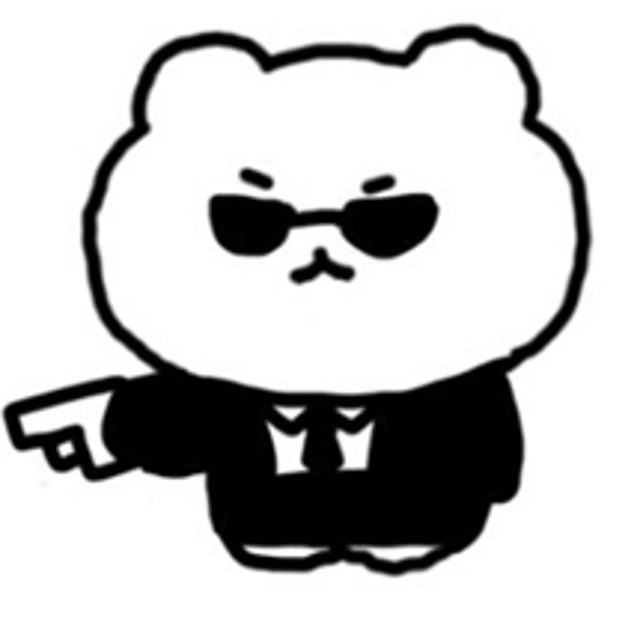

['H', 'T', '__abs__', '__add__', '__and__', '__array__', '__array_priority__', '__array_wrap__', '__bool__', '__class__', '__complex__', '__contains__', '__cuda_array_interface__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__div__', '__dlpack__', '__dlpack_device__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__iand__', '__idiv__', '__ifloordiv__', '__ilshift__', '__imod__', '__imul__', '__index__', '__init__', '__init_subclass__', '__int__', '__invert__', '__ior__', '__ipow__', '__irshift__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__long__', '__lshift__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__nonzero__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__', '__rdiv__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rfloordiv__', '__rls

In [53]:
def result(image_path):
    img = Image.open(image_path)
    x, y = img.size
    L, M = max(x,y), min(x,y)
    if x == L:
        img = img.resize([640,int(640/L * M)])
    else:
        img = img.resize([int(640/L * M), 640])
    results = model1(img)
    if len(results.xywh[0]):
        
        xywhn_list = results.xywhn[0]
        del_idx = []
        for i in range(len(xywhn_list)-1):
            src = xywhn_list[i]
            for j in range(i+1, len(xywhn_list)):
                tar = xywhn_list[j]
                
                if abs(src[0] - tar[0]) <= 0.05 and abs(src[1] - tar[1]) <= 0.05:
                    if src[4] > tar[4]:
                        del_idx.append(j)
                    else:
                        del_idx.append(i)
            if src[4] < 0.3:
                del_idx.append(i)
        else:
            if xywhn_list[-1][4] < 0.3:
                del_idx.append(i+1)
            del_idx = sorted(list(set(del_idx)), reverse=True)
            for di in del_idx:
                if di == len(results.pred[0]):
                    results.pred[0] = results.pred[0][:di, :]
                else:
                    results.pred[0] = torch.cat((results.pred[0][:di, :], results.pred[0][di+1:, :]), dim=0)
    results.show()
    
    return results

image_path= '../../../99791739.png'
res = result(image_path)

print(res.pred[0].__dir__())

print(int(res.pred[0].sum()))

# print(res.__dir__())

# image = cv2.imread(image_path)

# x, y, _ = image.shape
# L, M = max(x,y), min(x,y)
# if x == L:
#     image = cv2.resize(image, [640,int(640/L * M)])
# else:
#     image = cv2.resize(image, [int(640/L * M), 640])

# for box in res.pred[0]:
#     x1, y1, x2, y2, _, _ = map(int, box)
#     cv2.line(image, (x1, y1), (x1, y2), (0, 255, 0), 5)
#     cv2.line(image, (x1, y1), (x2, y1), (0, 255, 0), 5)
#     cv2.line(image, (x2, y2), (x1, y2), (0, 255, 0), 5)
#     cv2.line(image, (x2, y2), (x2, y1), (0, 255, 0), 5)

# cv2.imshow("Result", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# res.files[0] = 'XX.jpg'

# res.save(save_dir='./tmp_img/', exist_ok=False)

In [6]:
image = cv2.imread('./5_total_data/train/images/buquet_0003.jpg')

x, y, _ = image.shape
L, M = max(x,y), min(x,y)
if x == L:
    image = cv2.resize(image, [640,int(640/L * M)])
else:
    image = cv2.resize(image, [int(640/L * M), 640])

# 바운딩 박스의 좌표를 지정합니다.
x, y, w, h, _, _ = map(int, R.xywh[0][3])

# 바운딩 박스로부터 관심 영역(ROI)을 추출합니다.
x = x - w//2
y = y - h//2
roi = image[y:y+h, x:x+w]

# 관심 영역에서 윤곽을 검출합니다.
# 필요한 경우, 필터링, 이진화, 엣지 검출 등의 전처리 과정을 적용할 수 있습니다.
gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
_, threshold = cv2.threshold(gray_roi, 128, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 윤곽들을 바운딩 박스 좌표에 맞게 변환합니다.
for cnt in contours:
    cnt[:, :, 0] += x
    cnt[:, :, 1] += y

# 원본 이미지에 윤곽을 그립니다.
cv2.drawContours(image, contours, -1, (0, 255, 0), 2)

# 결과 이미지를 출력합니다.
cv2.imshow("Result", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

NameError: name 'R' is not defined

In [25]:
import cv2
import numpy as np
from scipy import stats

color_ranges = {
    "white": (np.array([200, 200, 200]), np.array([255, 255, 255])),
    "yellow": (np.array([200, 200, 0]), np.array([255, 255, 128])),
    "light_yellow": (np.array([230, 230, 100]), np.array([255, 255, 200])),
    "orange": (np.array([200, 100, 0]), np.array([255, 200, 128])),
    "pink": (np.array([200, 0, 128]), np.array([255, 200, 200])),
    "light_pink": (np.array([255, 192, 203]), np.array([255, 222, 223])),
    "red": (np.array([128, 0, 0]), np.array([255, 128, 128])),
    "purple": (np.array([128, 0, 128]), np.array([200, 128, 200])),
    "light_purple": (np.array([200, 150, 200]), np.array([230, 190, 230])),
    "blue": (np.array([0, 0, 128]), np.array([128, 200, 255])),
    "lavender": (np.array([150, 100, 200]), np.array([200, 150, 255])),
    "green": (np.array([0, 128, 0]), np.array([128, 255, 128])),
}

def mode_color(image, bounding_box):
    
    x,y,w,h = bounding_box
    object_pixels = image[y:y+h, x:x+w]

#     mean_color = cv2.mean(object_pixels)[:3]
#     return mean_color


    # 객체 픽셀을 1차원 배열로 변환합니다.
    reshaped_pixels = object_pixels.reshape(-1, 3)

    # 마스크를 적용한 영역에서 검은색(0, 0, 0) 픽셀을 제거합니다.
    valid_pixels = reshaped_pixels[~np.all(reshaped_pixels == 0, axis=1)]

    # 최빈값 색상을 계산합니다.
    mode_color = stats.mode(valid_pixels, axis=0)[0][0]
    
    
    return mode_color

# 이미지 파일을 불러옵니다.
image = cv2.imread('./5_total_data/train/images/buquet_0003.jpg')

x, y, _ = image.shape
L, M = max(x,y), min(x,y)
if x == L:
    image = cv2.resize(image, [640,int(640/L * M)])
else:
    image = cv2.resize(image, [int(640/L * M), 640])

# # 바운딩 박스의 좌표를 지정합니다.
x, y, w, h, _, _ = map(int, res.xywh[0][3])

# # 바운딩 박스로부터 관심 영역(ROI)을 추출합니다.
x = x - w//2
y = y - h//2

bounding_box = (x,y,w,h)

# 윤곽들에 대해 최빈값 색상을 구합니다.
mod_color = mode_color(image, bounding_box)
print(f"Mode color: {mod_color}")

cv2.line(image, (x, y), (x+w, y), (0, 255, 0), 5)
cv2.line(image, (x, y), (x, y+h), (0, 255, 0), 5)
cv2.line(image, (x+w, y+h), (x+w, y), (0, 255, 0), 5)
cv2.line(image, (x+w, y+h), (x, y+h), (0, 255, 0), 5)

R,G,B = map(int, [mod_color[2], mod_color[1], mod_color[0]])
print(R, G, B)

color_list = []
for name, (lower, upper) in color_ranges.items():

    if np.all(lower <= np.array([R,G,B])) and np.all(upper >= np.array([R,G,B])):
        color_list.append(name)

print(color_list)

# 결과 이미지를 출력합니다.
cv2.imshow("Result", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

C:\Users\SSAFY\AppData\Local\Temp\ipykernel_16892\3810344296.py:36: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_color = stats.mode(valid_pixels, axis=0)[0][0]


Mode color: [  0 106 196]
196 106 0
['red']


In [23]:
if np.all(np.array([128, 0, 0]) <= np.array([R,G,B])) and np.all(np.array([R,G,B]) <= np.array([255,128,128])):
    print('ㅌ')

ㅌ


In [17]:
np.array([R,G,B])

array([196, 106,   0], dtype=uint8)

In [60]:
import cv2
import numpy as np

def classify_color(pixel, color_ranges):
    for color_name, (lower, upper) in color_ranges.items():
        if np.all(lower <= pixel) and np.all(pixel <= upper):
            return color_name
    return None

def mode_color_range(image, bounding_box, color_ranges):
    x, y, w, h = bounding_box
    object_pixels = image[y:y+h, x:x+w]

    color_counts = {color_name: 0 for color_name in color_ranges.keys()}

    for row in object_pixels:
        for pixel in row:
            color_name = classify_color(pixel, color_ranges)
            if color_name is not None:
                color_counts[color_name] += 1

    mode_color_name = max(color_counts, key=color_counts.get)
    return mode_color_name, color_counts

# 이미지 파일을 불러옵니다.
image = cv2.imread("./5_total_data/train/images/buquet_0003.jpg")

x, y, _ = image.shape
L, M = max(x,y), min(x,y)
if x == L:
    image = cv2.resize(image, [640,int(640/L * M)])
else:
    image = cv2.resize(image, [int(640/L * M), 640])

for xywh in R.xywh[0]:
# 바운딩 박스 지정
    x, y, w, h, _, _ = map(int, xywh)

    # 바운딩 박스로부터 관심 영역(ROI)을 추출합니다.
    x = x - w//2
    y = y - h//2

    bounding_box = (x,y,w,h)

    # 색상 범위를 정의합니다.
    color_ranges = {
        "red": (np.array([128, 0, 0]), np.array([255, 128, 128])),
        "orange": (np.array([200, 100, 0]), np.array([255, 200, 128])),
        "yellow": (np.array([200, 200, 0]), np.array([255, 255, 128])),
        "light_green": (np.array([128, 255, 128]), np.array([200, 255, 200])),
        "green": (np.array([0, 128, 0]), np.array([128, 255, 128])),
        "light_blue": (np.array([128, 200, 255]), np.array([200, 255, 255])),
        "blue": (np.array([0, 0, 128]), np.array([128, 200, 255])),
        "purple": (np.array([128, 0, 128]), np.array([200, 128, 200])),
        "pink": (np.array([200, 0, 128]), np.array([255, 200, 200])),
        "white": (np.array([200, 200, 200]), np.array([255, 255, 255]))
    }

    # 바운딩 박스의 최빈값 색상 범위를 구합니다.
    mode_color_name, color_counts = mode_color_range(image, bounding_box, color_ranges)
    print(f"Mode color range: {mode_color_name}")
    print(f"Color counts: {color_counts}")

Mode color range: blue
Color counts: {'red': 11, 'pink': 1, 'white': 8, 'orange': 0, 'blue': 3039, 'green': 2, 'purple': 1838, 'lavender': 2022, 'yellow': 0}
Mode color range: blue
Color counts: {'red': 0, 'pink': 11, 'white': 62, 'orange': 0, 'blue': 10446, 'green': 5, 'purple': 265, 'lavender': 248, 'yellow': 0}
Mode color range: blue
Color counts: {'red': 0, 'pink': 1078, 'white': 375, 'orange': 0, 'blue': 2663, 'green': 27, 'purple': 81, 'lavender': 1, 'yellow': 0}
Mode color range: purple
Color counts: {'red': 0, 'pink': 95, 'white': 17, 'orange': 0, 'blue': 859, 'green': 116, 'purple': 1934, 'lavender': 279, 'yellow': 0}
Mode color range: blue
Color counts: {'red': 0, 'pink': 0, 'white': 0, 'orange': 0, 'blue': 2659, 'green': 3, 'purple': 1127, 'lavender': 124, 'yellow': 0}
Mode color range: blue
Color counts: {'red': 2, 'pink': 0, 'white': 0, 'orange': 0, 'blue': 3258, 'green': 17, 'purple': 0, 'lavender': 0, 'yellow': 0}
Mode color range: blue
Color counts: {'red': 0, 'pink': 0